# Recommender systems - Project 3

## Abstract
In this project we evaluate latent factor based recommender system on Movie Lens data set using ALS (Alternative Least Squares factorization method). This method is subject to local minima and also overfitting problems. So we will use different techniques to avoid local minima and also eliminate overfitting. 

## Data pre-processing
The MovieLens data has several files, but we will use the following files for this project:
1. u.user (a tab delimited data set, containing the users details - users uniquely identified by user_id key)
2. u.item (a tab delimited data set, containing the movie details - movies uniquely identified by item_id)
3. u.data (a tab delimited data set, containing the user_id, item_id and the rating given to the item by the user)

We will choose 10 users randomly from u.user data set, and get all the movies rated by these users (using the u.data). We will confine our data set to only these 10 users, to keep our data simple.

### Importing all the required packages

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display # Allows the use of display() for DataFrames
import time
import pickle #To save the objects that were created using webscraping
import pprint
from lxml import html
import requests
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

### Reading the files 

We will read the u.data, u.user and u.item files, and extract the required columns (since we do not need all the columns for this project). Follow the comments in the code to know which columns are dropped. 

In [2]:
#Reading the movie information
movie_df=pd.read_table("u.item",sep="|" ,header=None)
#Selecting only the needed columns: "item_id","item_name" from u.item data set
movie_df=movie_df[[0,1]]
movie_df.columns = ["item_id","item_name"]

#Displaying sample data
print "Movie data frame sample rows:"
display(movie_df.head())

#Reading the user ID information, and 
#selecting columns: "user_id","age","gender","profession","zip". But we will not use the 
#gender, age, profession, zip
user_df=pd.read_table("u.user",sep="|" ,header=None)
user_df.columns=["user_id","age","gender","profession","zip"]

print "User data frame sample rows:"
display(user_df.head())

#Reading the user, movie ratings information
ratings_df=pd.read_csv("u.data",delimiter = "\t",header=None)
ratings_df.columns = ["user_id",  "item_id","rating","timestamp"]
#Dropping the timestamp info, since we do not need that information in this project
del ratings_df["timestamp"]

print "Displaying the ratings details (mapping between user id and item id):"
display(ratings_df.head())

Movie data frame sample rows:


,item_id,item_name
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


User data frame sample rows:


,user_id,age,gender,profession,zip
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


Displaying the ratings details (mapping between user id and item id):


,user_id,item_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


### Selecting the users randomly
We will select 10 random users in the following code block. Once the users are selected, we will get the list of all movie names rated by these 10 random users. A data frame is prepared with all the required columns (discarding the unnecessary columns). 

In [3]:
#Selecting only 10 users randomly
#Set the seed, to 1234 to reproduce the same results
np.random.seed(1234)
uids = np.random.randint(1,user_df["user_id"].max(),10)

user_df=user_df.iloc[uids]
#user_df=user_df[user_df["user_id"].isin(uids)]
#user_df.index = user_df["user_id"]
uids = [i+1 for i in uids]
#print uids
print "Here are the randomly selected users:\n"
display(user_df)

#Combined data frame
df = pd.merge(pd.merge(user_df,ratings_df),movie_df)
print "All columns combined:"
display(df.head())
#df.sort_values(["item_id"])

print "The combined data frame has {} rows and {} columns".format(df.shape[0],df.shape[1])



Here are the randomly selected users:



,user_id,age,gender,profession,zip
816,817,19,M,student,60152
724,725,21,M,student,91711
295,296,43,F,administrator,16803
54,55,37,M,programmer,01331
205,206,14,F,student,53115
373,374,36,M,executive,78746
665,666,44,M,administrator,61820
656,657,26,F,none,78704
690,691,34,M,educator,60089
280,281,15,F,student,06059


All columns combined:


,user_id,age,gender,profession,zip,item_id,rating,item_name
0,817,19,M,student,60152,748,4,"Saint, The (1997)"
1,725,21,M,student,91711,748,4,"Saint, The (1997)"
2,206,14,F,student,53115,748,4,"Saint, The (1997)"
3,691,34,M,educator,60089,748,4,"Saint, The (1997)"
4,281,15,F,student,06059,748,5,"Saint, The (1997)"


The combined data frame has 899 rows and 8 columns


## Splitting the data into test and train data sets
We will split the data into 20:80 ratio for test:train data. We will use stratified sampling on the "user_id" so that we have some data for each user in both test and training data.

In [5]:
from sklearn.cross_validation import train_test_split
print "Final data frame to develop our model"
df_final = df[["user_id","item_id","rating"]]
df_final.head()

#Splitting the data.
print "This data frame has been split into test and traiing data sets. 20% for test and 80% for training"
X_train, X_test = train_test_split(df_final, test_size=0.2, random_state=1, stratify=df_final["user_id"])
print "The training data has {} users and {} movies".format(len(set(X_train["user_id"])),len(set(X_train["item_id"])))
print "The test data has {} users and {} movies".format(len(set(X_test["user_id"])),len(set(X_test["item_id"])))

Final data frame to develop our model
This data frame has been split into test and traiing data sets. 20% for test and 80% for training
The training data has 10 users and 472 movies
The test data has 10 users and 157 movies


The above display confirms that the training and test data sets have the same users. 

## Building utility matrix
We will build a utility matrix for training data.

In [75]:
X_test

,user_id,item_id,rating
259,374,210,4
523,374,476,2
470,206,1313,1
792,666,339,4
341,296,523,4
428,296,1251,5
313,666,435,4
493,657,346,4
197,296,272,5
793,666,177,3


In [6]:
#display(df_final.head())
print "We have {} movies rated by the 10 users (randomly selected) in the training data".format(len(set(df_final["item_id"])))

#Building the utility matrix
Utility = df_final.pivot(index="user_id",columns="item_id",values="rating")
Utility_train = X_train.pivot(index="user_id",columns="item_id",values="rating")
print "Sample data from utility matrix is displayed below. NaNs represent that the user has not rated the movie:"
print "Only some of the initial columns are displayed"

#Utility_train.reset_index(inplace=True)
#Utility_train.reset_index(drop=True,inplace=True)
#print Utility.index.name
Utility.columns.names=[" "]
Utility_train.iloc[:,range(0,20)]
#utility_matrix = X_train.pivot(index='user_id',columns='item_id',values='rating')


We have 546 movies rated by the 10 users (randomly selected) in the training data
Sample data from utility matrix is displayed below. NaNs represent that the user has not rated the movie:
Only some of the initial columns are displayed


item_id,1,2,4,5,7,8,9,10,11,12,13,15,17,19,22,23,24,25,26,27
user_id,,,,,,,,,,,,,,,,,,,,
55,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN
206,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
296,5.0,NaN,NaN,NaN,5.0,NaN,NaN,2.0,5.0,NaN,NaN,3.0,NaN,5.0,4.0,5.0,2.0,NaN,NaN,NaN
374,4.0,4.0,2.0,NaN,1.0,NaN,NaN,NaN,NaN,4.0,NaN,3.0,2.0,NaN,NaN,3.0,NaN,5.0,NaN,4.0
657,3.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
666,NaN,NaN,5.0,2.0,4.0,NaN,NaN,NaN,4.0,4.0,4.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,3.0,NaN
691,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
725,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,4.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN


## Implementing alternating least squares method for matrix factorization

We will use alternating least squares method for matrix factorization. We assume that the utility matrix is named as M, with _n_ rows and _m_ columns. This means that the utility matrix has _n_ users and _m_ items (or movies). This matrix will be decomposed into U and V matrices with _nXd_ and _dXm_ dimensions respectively, where _d_ is the desired number of latent factors. 

In [7]:
4*np.eye(4)

array([[ 4.,  0.,  0.,  0.],
       [ 0.,  4.,  0.,  0.],
       [ 0.,  0.,  4.,  0.],
       [ 0.,  0.,  0.,  4.]])

In [ ]:
def build_U(U,V,r_u,reg,d):
    temp_1 = np.dot(V.t,V)+reg * np.eye(d)
    pd.DataFrame(np.linalg.pinv(temp_1.values), df.columns, df.index)
    
    r_u,()

In [34]:
## Building U:
def build_U(M,U,V,r,s,reg):
    #Function to compute the U[r,s] entry
    
    #Get the s row from V
    V_s=V[s,:].copy()
    #Get the r row from M
    M_r=M[r,:].copy()
    
    #Get the r row from U
    U_r = U[r,:].copy()
    U_r[s] = 0
    #Get the r col from V
    V_r = V[:,r].copy()
    V_r[s] = 0
    #print "V_s:{}".format(V_s)
    #print "M_r:{}".format(M_r)
    #print "U_r:{}".format(U_r)
    #print "V_r:{}".format(V_r)
    M_r = M_r - np.dot(U_r,V_r)
    V_s[np.isnan(M_r)] = 0
    M_r[np.isnan(M_r)] = 0
    
    #print "M_r:{}".format(M_r)
    return np.dot(V_s,M_r)/(np.dot(V_s,V_s) + reg)

def build_V(M,U,V,r,s,reg):
    #Get the r col from U
    U_r=U[:,r].copy()
    #Get the s col from M
    M_s=M[:,s].copy()
        
    #Get the s col from V
    V_s = V[:,s].copy()
    V_s[r] = 0
    #Get the s row from U
    U_s = U[r,:].copy()
    U_s[r] = 0
    #print "V_s:{}".format(V_s)
    #print "M_s:{}".format(M_s)
    #print "U_r:{}".format(U_r)
    #print "U_s:{}".format(U_s)
    M_s = M_s - np.dot(V_s,U_s)
    U_r[np.isnan(M_s)] = 0
    M_s[np.isnan(M_s)] = 0
    
    #print "M_s:{}".format(M_s)
    return np.dot(U_r,M_s)/(np.dot(U_r,U_r) + reg)

def get_error(M,U,V):
    return np.nanmean(np.square(M - np.dot(U,V)))



In [13]:
M = np.array([[5,2,4,4,3],[3,1,2,4,1],[2,np.nan,3,1,4],[2,5,4,3,5],[4,4,5,4,np.nan]])
print M
U = np.ones((5,2),dtype=np.float)
V = np.ones((2,5),dtype=np.float)
print U
print V

[[  5.   2.   4.   4.   3.]
 [  3.   1.   2.   4.   1.]
 [  2.  nan   3.   1.   4.]
 [  2.   5.   4.   3.   5.]
 [  4.   4.   5.   4.  nan]]
[[ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]]
[[ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]]


In [59]:
error = list()
U_rows, U_columns = U.shape
V_rows, V_columns = V.shape
convergence = 1
reg = 2
count = 1
while convergence >= 0.01 or count < 1000:
    #Loop the rows of U first
    for i in xrange(U_rows):
        for j in xrange(U_columns):
            r = i
            s = j
            U[r,s] = build_U(M,U,V,r,s,reg)
            error.append(get_error(M,U,V))
    for i in xrange(V_rows):
        for j in xrange(V_columns):
            r = i
            s = j
            V[r,s] = build_V(M,U,V,r,s,reg)
            error.append(get_error(M,U,V))
    convergence = error[-2] - error[-1]  
    count = count + 1
    print convergence
    print U
    print V
            

0.0328435633919
[[ 1.85714286  1.24489796]
 [ 0.85714286  0.95918367]
 [ 1.          1.        ]
 [ 2.          1.28571429]
 [ 2.16666667  1.38888889]]
[[ 1.05256984  0.98614702  1.33297971  1.05256984  1.19056309]
 [ 1.53838351  1.40455511  1.68678213  1.53838351  1.47983844]]
0.0597627479831
[[ 1.14474463  1.35548916]
 [ 0.55427076  0.93487866]
 [ 0.55482816  0.93278578]
 [ 1.23740433  1.37542182]
 [ 1.42663761  1.37497259]]
[[ 0.85724892  0.89512488  1.09323712  0.86954241  0.9881003 ]
 [ 1.80056348  1.59199768  2.01275209  1.7985688   1.75173045]]
0.0332949933751
[[ 0.83743252  1.44824139]
 [ 0.4826383   0.88776802]
 [ 0.47090924  0.93956134]
 [ 1.00210345  1.43195208]
 [ 1.27667146  1.44336745]]
[[ 0.53112991  0.71425646  0.73511289  0.56362623  0.67382264]
 [ 1.90305618  1.65433463  2.13586203  1.88643821  1.86979548]]
0.00604529191962
[[ 0.5924546   1.57941668]
 [ 0.48244032  0.89083814]
 [ 0.41794359  0.99687068]
 [ 0.96028949  1.52765134]
 [ 1.10826354  1.62596726]]
[[ 0.18223

In [60]:
print np.dot(U,V)
print M

[[ 3.12956164  2.89828151  3.61080046  3.12289363  3.22410756]
 [ 1.79218801  1.71892011  2.09571166  1.80430978  1.87845878]
 [ 1.98328596  1.85428112  2.2965507   1.9837912   2.05273742]
 [ 3.09756228  3.02319974  3.64683828  3.13259312  3.27504815]
 [ 3.31261764  3.26670013  3.91589321  3.35913326  3.52067156]]
[[  5.   2.   4.   4.   3.]
 [  3.   1.   2.   4.   1.]
 [  2.  nan   3.   1.   4.]
 [  2.   5.   4.   3.   5.]
 [  4.   4.   5.   4.  nan]]


In [63]:
##Normalize the Utility matrix:
##Subtract the avg user rating and avg item rating from the item in M
#print M
def normalize(l):
    return np.nanmean(l)

M=Utility_train
M = np.array(M)
items_mean=np.apply_along_axis(normalize,0,M)
#print items_mean
#users_mean = np.apply_along_axis(normalize,1,M)

#print M
#print items_mean
#print users_mean
M_normalized = M[:,] - items_mean

#print M_normalized
users_mean = np.apply_along_axis(normalize,1,M_normalized)
#print users_mean

M_normalized = (M_normalized[:,].T- users_mean)
M_normalized = M_normalized.T
#print M_normalized
print np.nansum(M_normalized)    

5.55111512313e-15


In [41]:
temp1 = np.array([[1,2,3],[3,4,5],[6,7,8]])
temp2 = np.array([[10,20,30],[30,40,50],[60,70,80]])
for i in  

[1 2 3]
[3 4 5]
[6 7 8]


In [36]:

def get_U_V(M,d,reg):
    #M must be normalized
    M_rows,M_cols = M.shape
    factors = d
    U = np.ones((M_rows,factors),dtype=np.float)
    V = np.ones((factors,M_cols),dtype=np.float)
    error = list()
    error.append(get_error(M,U,V))
    U_rows,U_cols = U.shape
    V_rows,V_cols = V.shape
    
    for counter in xrange(1000):
        #Loop the rows of U first
        print "episode:{}".format(counter)
        for i in xrange(U_rows):
            for j in xrange(U_columns):
                r = i
                s = j
                U[r,s] = build_U(M,U,V,r,s,reg)
                error.append(get_error(M,U,V))
                if error[-1] >= error[-2]:
                    return [U,V,error]
        
        for i in xrange(V_rows):
            for j in xrange(V_columns):
                r = i
                s = j
                V[r,s] = build_V(M,U,V,r,s,reg)
                error.append(get_error(M,U,V))
                if error[-1] >= error[-2]:
                    return [U,V,error]


In [42]:

def get_U_V(M,d,reg):
    #M must be normalized
    M_rows,M_cols = M.shape
    factors = d
    U = np.ones((M_rows,factors),dtype=np.float)
    V = np.ones((factors,M_cols),dtype=np.float)
    error = list()
    error.append(get_error(M,U,V))
    U_rows,U_cols = U.shape
    V_rows,V_cols = V.shape
    
    for counter in xrange(1000):
        #Loop the rows of U first
        print "episode:{}".format(counter)
        for i in xrange(d):
            for j in xrange(U_rows):
                r = j
                s = i
                U[r,s] = build_U(M,U,V,r,s,reg)
                error.append(get_error(M,U,V))
                if error[-1] >= error[-2]:
                    return [U,V,error]
        
            for j in xrange(V_columns):
                r = i
                s = j
                V[r,s] = build_V(M,U,V,r,s,reg)
                error.append(get_error(M,U,V))
                if error[-1] >= error[-2]:
                    return [U,V,error]


In [73]:
#import itertools
#U_iterator = list(itertools.product(xrange(M_rows),xrange(d)))
#V_iterator = list(itertools.product(xrange(d),xrange(M_cols)))
#i = 0
#j = 0
#U_len = len(U_iterator)
#V_len = len(V_iterator)
#max_elements = U_len + V_len
#counter = 0
#while counter <= max_elements:
#    r,s = U_iterator[counter % U_len]
#    U[r,s] = build_U(M,U,V,r,s,reg)
#    error.append(get_error(M,U,V))
#    if error[-1] >= error[-2]:
#           return [U,V,error]
#    r,s = V_iterator[counter % V_len]
#    V[r,s] = build_V(M,U,V,r,s,reg)
#    error.append(get_error(M,U,V))
#    if error[-1] >= error[-2]:
#           return [U,V,error]        
#    counter++

import itertools    
def get_U_V(M,factors,reg):
    #M must be normalized
    M_rows,M_cols = M.shape
    U = np.ones((M_rows,factors),dtype=np.float)
    V = np.ones((factors,M_cols),dtype=np.float)
    error = list()
    error.append(get_error(M,U,V))
    U_iterator = list(itertools.product(xrange(M_rows),xrange(factors)))
    V_iterator = list(itertools.product(xrange(factors),xrange(M_cols)))
    U_len = len(U_iterator)
    V_len = len(V_iterator)
    max_elements = U_len + V_len
    
    for episode in xrange(20):
        #Loop the rows of U first
        print "episode:{}, error:{}".format(episode,error[-1])
        counter = 0
        while counter <= max_elements:
            r,s = U_iterator[counter % U_len]
            U[r,s] = build_U(M,U,V,r,s,reg)
            error.append(get_error(M,U,V))
            #if error[-1] >= error[-2]:
                   #return [U,V,error]
            r,s = V_iterator[counter % V_len]
            V[r,s] = build_V(M,U,V,r,s,reg)
            error.append(get_error(M,U,V))
            #if error[-1] >= error[-2]:
             #      return [U,V,error]        
            counter=counter+1

    return [U,V,error]


In [74]:
#Normalizing M and calling the get_U_V function defined above
def normalize(l):
    return np.nanmean(l)

M=Utility_train
M = np.array(M)
items_mean=np.apply_along_axis(normalize,0,M)

M_normalized = M[:,] - items_mean

#print M_normalized
users_mean = np.apply_along_axis(normalize,1,M_normalized)
#print users_mean

M_normalized = (M_normalized[:,].T- users_mean)
M_normalized = M_normalized.T
#print M_normalized
#print np.nansum(M_normalized)    
get_U_V(M_normalized,2,2)

episode:0, error:4.34730183613
episode:1, error:0.215732672395
episode:2, error:0.232794887338
episode:3, error:0.224095592014
episode:4, error:0.217758870057
episode:5, error:0.213406141721
episode:6, error:0.211908990059
episode:7, error:0.211611555097
episode:8, error:0.211644567952
episode:9, error:0.211743194078
episode:10, error:0.211834811503
episode:11, error:0.211904244658
episode:12, error:0.211953161765
episode:13, error:0.211986718992
episode:14, error:0.21200958484
episode:15, error:0.212025184293
episode:16, error:0.212035861506
episode:17, error:0.212043190112
episode:18, error:0.212048227817
episode:19, error:0.212051691424


[array([[ 0.13861269,  0.08302515],
        [-1.21899732,  1.05539048],
        [ 0.44484461, -0.3068734 ],
        [ 1.46270619, -1.38638245],
        [-2.45437776,  2.33619624],
        [ 0.79971747, -0.87050954],
        [ 1.57889605, -1.47375962],
        [-0.02182592,  0.14668099],
        [ 0.10511397,  0.4406405 ],
        [ 0.09464358, -0.0140351 ]]),
 array([[ 0.03756951, -0.01088665,  0.58263627,  0.04773802,  0.67588462,
          0.0022977 , -0.01542157, -0.08640136, -0.03124841,  0.01105007,
          0.04773802, -0.01586665, -0.01088666, -0.09068094, -0.2573865 ,
          0.29285858, -0.08640136, -0.01088666,  0.047738  , -0.01088666,
         -0.37000765, -0.01088665, -0.37001546, -0.02201957, -0.01088665,
         -0.01088665,  0.04774071, -0.12768824, -0.04181826, -0.01088665,
          0.53168787, -0.20389836, -0.08640537, -0.01041745,  0.20158162,
         -0.01088665, -0.37001556,  0.0477407 , -0.01088665, -0.14597735,
          0.0477407 , -0.01088665, -0.08640537

In [59]:
import itertools
#for element in itertools.product(xrange(3),xrange(3)):
#    print temp1[element]
#temp1
element = list(itertools.product(xrange(3),xrange(3)))
print element
temp1[element[8]]

[(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]


8

In [43]:
get_U_V(M_normalized,2,2)

episode:0


[array([[-0.89473684,  1.        ],
        [-0.96226415,  1.        ],
        [-0.91304348,  1.        ],
        [-0.98319328,  1.        ],
        [-0.99095023,  1.        ],
        [-0.92      ,  1.        ],
        [-0.98989899,  1.        ],
        [-0.92857143,  1.        ],
        [-0.90909091,  1.        ],
        [-0.93548387,  1.        ]]),
 array([[ 0.68258502,  1.        ,  1.        ,  1.        ,  1.        ,
          1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
          1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
          1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
          1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
          1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
          1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
          1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
          1.        ,  1.        ,  1.        

In [5]:
from surprise import SVD
from surprise import Dataset
from surprise import evaluate, print_perf


# Load the movielens-100k dataset (download it if needed),
# and split it into 3 folds for cross-validation.
#data = Dataset.load_builtin('ml-100k')
final_df.split(n_folds=3)

# We'll use the famous SVD algorithm.
algo = SVD()

# Evaluate performances of our algorithm on the dataset.
perf = evaluate(algo, final_df, measures=['RMSE', 'MAE'])

print_perf(perf)

ImportError: DLL load failed: A dynamic link library (DLL) initialization routine failed.

Since we have duplicate movie names in the combined data frame displayed above, we will use the movie_df (which has the unique movies identified by the item_id) to get the actors list from IMDB website. Also note that we will be getting only the leading actors in the movie along with the director and writer names only (to make the list simple).



### Scraping the IMDB web pages to extract actors, writers and directors
Let us display a row from movie_df data frame to know how the data looks. The item_url column has URL to the IMDB web page, where the movie details are present. But not all the links are correct (there are some formatting problems, and I fixed that wherever possible).

In [4]:
movie_df[movie_df["item_id"] == 2]

,item_id,item_name,item_url
1,2,GoldenEye (1995),http://us.imdb.com/M/title-exact?GoldenEye%20(...


### Identifying the movies list
The below code identifies which movie details need to be scraped to obtain the actors list. These movies are the ones rated by the 10 random users we selected.

In [5]:
#Let us get the list of movies to be scraped
selected_movie_id=df["item_id"].unique()
#print selected_movie_id
selected_movies=movie_df.iloc[selected_movie_id]
#selected_movies=movie_df[movie_df["item_id"].isin(selected_movie_id)]

selected_movies.index=selected_movies["item_id"]
#display(selected_movies.head())
selected_movies.drop(["item_id"],axis=1,inplace=True)
#Display some records
print "Some of the movies rated by the 10 random users is displayed below:"
display(selected_movies.head())

Some of the movies rated by the 10 random users is displayed below:


,item_name,item_url
item_id,,
749,"MatchMaker, The (1997)",http://us.imdb.com/M/title-exact?Matchmaker%2C...
125,Phenomenon (1996),http://us.imdb.com/M/title-exact?Phenomenon%20...
119,Maya Lin: A Strong Clear Vision (1994),http://us.imdb.com/M/title-exact?Maya%20Lin:%2...
2,GoldenEye (1995),http://us.imdb.com/M/title-exact?GoldenEye%20(...
359,"Assignment, The (1997)",http://us.imdb.com/M/title-exact?Assignment%2C...


### Demo of web scraping
We will scrape the actors details of <a href=http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)>Toy Story (1995)</a>  to demonstrate how the web scraping works. Once we validate that we are successfully getting the actors list, we can implement the same logic in a loop to pull the actors list for all the movies selected (movies rated by the users selected).

In [6]:
page = requests.get('http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)')
tree = html.fromstring(page.content)
actors = tree.xpath('//*[contains(concat( " ", @class, " " ), concat( " ", "credit_summary_item", " " ))]//*[contains(concat( " ", @class, " " ), concat( " ", "itemprop", " " ))]/text()')
print actors

['John Lasseter', 'John Lasseter', 'Pete Docter', 'Tom Hanks', 'Tim Allen', 'Don Rickles']


We can see that the artists for the Toy story were pulled successfully into a list (even though Toy story is an animated movie, these artists gave dubbing to the characters in the movie). Click this <a href=http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)>Toy Story (1995)</a> to visit the IMDB web page containing the details of toy story.

The number of movies that need to be scraped is given below:

In [20]:
print "We need to scrape {} movies".format(selected_movies.shape[0])

We need to scrape 546 movies


Let us implement the IMDB web scraping to pull the actors list of all the selected movies in an automated fashion. The following code block will run for more than an 2 hours (since I kept a sleep time of 3 secs between successive requests in order to avoid constant hits to the IMDB server). Also this code has failed several times, since IMDB rejected the requests, after parsing approximately 300 movie details. But I could successfully parse the 546 movies once (in the night time, during the less web traffic hours), and the list of actors acted in those 546 movies were saved as a pickled object. So I am commenting the following code (to avoid accidentally executing the web scraper). To execute the code, you have to uncomment all the lines. Where ever you have double comments (##), you may remove the first "#", so that the line still remains as a comment.

In [21]:
##Track the time
#start = time.time()
#selected_movies.index
#actors_list = list()
#j = 0

##Iterate the data frame by index
#for ind in selected_movies.index:
    ##Get the movie name and the URL of the IMDB
    #movie_name= selected_movies.loc[ind]["item_name"]
    #movie_url= selected_movies.loc[ind]["item_url"]
    
    ##Pull the page
    #page = requests.get(movie_url)
    #tree = html.fromstring(page.content)
    #actors = tree.xpath('//*[contains(concat( " ", @class, " " ), concat( " ", "credit_summary_item", " " ))]//*[contains(concat( " ", @class, " " ), concat( " ", "itemprop", " " ))]/text()')
    
    ##Extract the actors
    #actors=[i for i in actors if i != '\n']
    #actors = filter(lambda name: name.strip(), actors)    
    
    ##Some URL links are not correct. So if we do not get any actors list, then
    ##fix the error and pull the data again
    #if len(actors) == 0:
        #if len(movie_name.split(",")) == 2:
            #x=movie_name.split("(")
            #year = x[-1]
            #year = "("+year.strip()
            #name = x[0]

            #name = name.split(",")
            #if len(name) > 1:
                #name = name[-1]+",".join(name[0:-1])
            #name=str(name)
            #name = name.strip()
            #temp_url = name+"%20"+year

            #temp_url=temp_url.replace(" ","%20")
            #temp_url="http://us.imdb.com/M/title-exact?"+temp_url
            #try:
                 #page = requests.get(temp_url)
            #except:
                #print temp_url
            #tree = html.fromstring(page.content)
            #actors = tree.xpath('//*[contains(concat( " ", @class, " " ), concat( " ", "credit_summary_item", " " ))]//*[contains(concat( " ", @class, " " ), concat( " ", "itemprop", " " ))]/text()')
            #actors=[i for i in actors if i != '\n']
            #actors = filter(lambda name: name.strip(), actors)    

    ##Collect the actors list to actors_list
    #actors_list.append(actors)
    
    ##Sleep for 3 seconds to avoid bombarding IMDB server with immediate requests
    #time.sleep(3)
    
    ##j variable will keep track of how many URLs were processed
    #j = j+1
    
    ##Display the status of scraping (how many URLs were processed till now?)
    #if j % 50 == 0:
        #print "processed {} URLs".format(j)

#end = time.time()

#print "Total processing time {} secs".format(end - start)

#len(actors_list)

##Save the actors list, so that we do not have to gather the actors details again
#import pickle
#actors_data = {"actors_data":actors_list}
#f = open('actors.pkl','wb')
##with open('actors.pkl','wb') as f:
#pickle.dump(actors_list,f,-1)
#f.close()        


Now we are reading the actors list which was saved as a pickeled object.

In [22]:
import pickle
import pprint
#To read back the pickled data
f= open('actors.pkl', 'rb')
actors_list = pickle.load(f)
#Uncomment the following lines to verify
#pprint.pprint(actors_list)
#actors_list[1][0]

Adding the actors lists to the data frame.

In [23]:
import warnings
warnings.filterwarnings('ignore')
#print len(actors_list)
#print selected_movies.shape
selected_movies["actors"]=actors_list

#Get the list of movies which are not scraped successfully
remaining_movies=selected_movies[selected_movies.astype(str)['actors'] == '[]']

print "There are {} movies which are NOT scraped successfully.".format(remaining_movies.shape[0])
print "We will delete these movies from our movie list"
selected_movies=selected_movies[selected_movies.astype(str)['actors'] != '[]']
print "After eliminating the movies which were not successfully scraped from the list, we obtained the following data frame finally"
print "The final data frame has {} movies".format(selected_movies.shape[0])

display(selected_movies.head())

There are 96 movies which are NOT scraped successfully.
We will delete these movies from our movie list
After eliminating the movies which were not successfully scraped from the list, we obtained the following data frame finally
The final data frame has 450 movies


,item_name,item_url,actors
item_id,,,
749,"MatchMaker, The (1997)",http://us.imdb.com/M/title-exact?Matchmaker%2C...,"[Mark Joffe, Greg Dinner, Karen Janszen, Janea..."
125,Phenomenon (1996),http://us.imdb.com/M/title-exact?Phenomenon%20...,"[Jon Turteltaub, Gerald Di Pego, John Travolta..."
119,Maya Lin: A Strong Clear Vision (1994),http://us.imdb.com/M/title-exact?Maya%20Lin:%2...,"[Freida Lee Mock, Freida Lee Mock, Maya Lin]"
2,GoldenEye (1995),http://us.imdb.com/M/title-exact?GoldenEye%20(...,"[Martin Campbell, Ian Fleming, Michael France,..."
359,"Assignment, The (1997)",http://us.imdb.com/M/title-exact?Assignment%2C...,"[Christian Duguay, Dan Gordon, Sabi H. Shabtai..."


### Splitting the data into test and train data

Let us split some data from each user into train and test data sets. We will use the train to build the recommendation models, and use the test data to measure the accuracy of our models. The test data consists of 15 movies which were rated by the user ID 374. We will pretend that the user 374 has not rated these 15 movies, so that we can get the MAE (Mean Absolute Error) between the actual and the predicted ratings for the user 374. The test data consists of 15 movie ratings out of the 138 movies rated by 374 user ID. Continue reading the document to find the reason why the user ID 374 is chosen for evaluating the alogrithms performance.

In [24]:
#Create final_ratings_df data frame that contains the user ID, 
#movie ID and the rating (only the data belonging to 10 random users is included in the final_ratings_df)

temp1=ratings_df[(ratings_df["user_id"].isin(uids))]
 
movies_list = selected_movies.index
 
temp1 = temp1[temp1["item_id"].isin(movies_list)]
final_ratings_df=temp1
 
movies_list = temp1["item_id"].unique()
selected_movies=selected_movies.loc[movies_list]


Display how many ratings were given by each of the 10 random users for the movies we scraped.

,count
user_id,
55,10
725,13
281,14
691,15
657,17
817,19
206,26
296,83
666,135


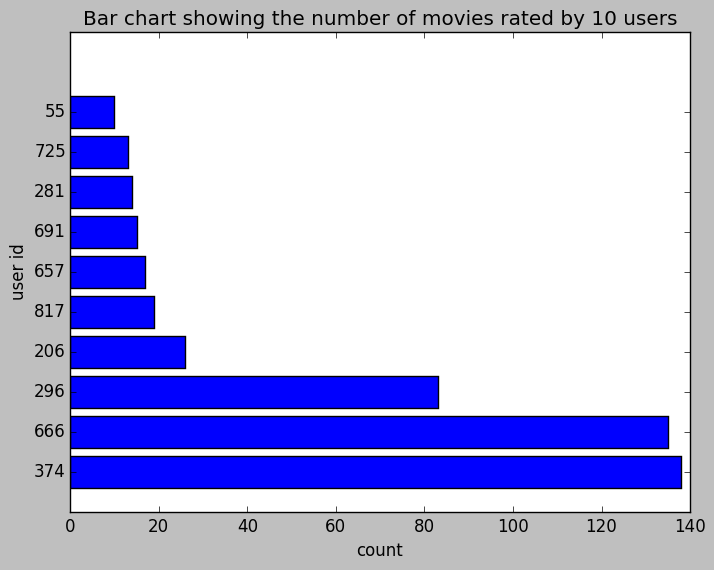

In [25]:
#ratings_df
%matplotlib inline
import matplotlib.pyplot as plt

display_df=pd.DataFrame(final_ratings_df.groupby("user_id")["item_id"].count())
display_df.columns = ["count"]
display_df=display_df.sort_values("count")
display(display_df)

plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
items = display_df.index
y_pos = np.arange(len(items))
count = display_df["count"]


ax.barh(y_pos, count, align='center',
        color='blue')
ax.set_yticks(y_pos)
ax.set_yticklabels(items)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('count')
ax.set_ylabel('user id')
ax.set_title('Bar chart showing the number of movies rated by 10 users')

plt.show()

The above bar chart shows that, out of the 10 random users selected, the users 666 and 374 have rated more than 100 movies. We will use some of the movies rated by the user ID 374 as our test data (since this user has rated 138 movies, and taking out 15 movies out of 138 movies should have less impact in predicting the user ratings). The 15 movies taken out from 374 user ID will be used to evaluate the accuracy of our predictions.

The below code splits the test and training data frames.

In [26]:
from sklearn.model_selection import train_test_split

#Splitting the 374 user id's data into test and train.
#The train data has all the movies rated by 374 except the 15 movie ratings he made
X_train, X_test = train_test_split(final_ratings_df[final_ratings_df["user_id"]==374], test_size=15, random_state=42)

#Make all ratings of 15 movies selected for test as NA (for user 374)
final_ratings_df=final_ratings_df.drop(final_ratings_df[(final_ratings_df["user_id"]==374)].index)
X_test_temp = X_test.copy()
X_test_temp["rating"] = None
X_train=final_ratings_df.append(X_train)
X_train = X_train.append(X_test_temp)
#X_train[final_ratings_df[(final_ratings_df["user_id"]==374) & ]
X_train.head()


,user_id,item_id,rating
317,296,508,5.0
402,296,20,5.0
526,281,338,2.0
988,296,228,4.0
1131,296,222,5.0


Displaying the user 374 data in the training dataset. Note that the ratings of test movie IDs rated by this user are changed to Nan, so that we can ignore the NaNs when we compute the mean to normalize the data.

In [27]:
X_train[X_train["user_id"] == 374]

,user_id,item_id,rating
21536,374,1014,1.0
15486,374,28,5.0
12934,374,195,3.0
47183,374,412,4.0
27214,374,226,5.0
66825,374,294,2.0
8921,374,173,3.0
68810,374,273,2.0
18764,374,230,5.0
63364,374,527,4.0


# Content based filtering

## Preparation of item profile

Using the above displayed data frame we will now prepare the item profile, using the actors from each of the movie.

In [28]:
#Define a function that converts a list to a dict
def list_to_dict(l):
    l = list(set(l)) #eliminate duplicate values, if any, in the list
    #Return a dictionary with key as the actor's name and 1 as the key's value
    return {el:1 for el in l} 

#Convert the list of all actors as a list of dictionaries
d=list(selected_movies["actors"].apply(list_to_dict))

#Convert the list of dictionaries to a data frame
d=pd.DataFrame(d)

#Set the row indices of the data frame to the same as the movies data frame, so that we can join the data frames later
d.index = selected_movies.index

#Concatenate the data frames, based on the row indices
items_profile = pd.concat([selected_movies,d],axis=1)

print "The items profile data frame has {} rows and {} columns. The initial 3 rows are displayed below:"\
.format(items_profile.shape[0],items_profile.shape[1])

display(items_profile.head(n=3))

#items_profile[['Mark Joffe', 'Greg Dinner']]



The items profile data frame has 263 rows and 1030 columns. The initial 3 rows are displayed below:


,item_name,item_url,actors,A.S. Byatt,Aaron Sorkin,Adam Sandler,Agga Olsen,Agnieszka Holland,Aidan Quinn,Akira Kurosawa,...,William Wisher Jr.,William Wyler,Winona Ryder,Winston Groom,Wolfgang Petersen,Woody Allen,Woody Gelman,Woody Harrelson,Zack Duhame,Zinedine Soualem
item_id,,,,,,,,,,,,,,,,,,,,,
508,"People vs. Larry Flynt, The (1996)",http://us.imdb.com/M/title-exact?People%20vs.%...,"[Milos Forman, Scott Alexander, Larry Karaszew...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
20,Angels and Insects (1995),http://us.imdb.com/M/title-exact?Angels%20and%...,"[Philip Haas, A.S. Byatt, Belinda Haas, Mark R...",1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
338,Bean (1997),http://us.imdb.com/M/title-exact?Bean+(1997),"[Mel Smith, Rowan Atkinson, Richard Curtis, Ro...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Most of the values of the item profile are NaN values, indicating that a small number of actors acted in all the movies. Let us make sure that we have the correct values at the corresponding actor value in the matrix. We will check in which of the selected movies the actor "Tom Hanks" has acted in. We will also display the same for the actress "Julia Roberts".

In [29]:
display(items_profile[["item_name","Tom Hanks"]].dropna())
display(items_profile[["item_name","Julia Roberts"]].dropna())

,item_name,Tom Hanks
item_id,,
845,That Thing You Do! (1996),1.0
28,Apollo 13 (1995),1.0
69,Forrest Gump (1994),1.0
88,Sleepless in Seattle (1993),1.0


,item_name,Julia Roberts
item_id,,
255,My Best Friend's Wedding (1997),1.0
319,Everyone Says I Love You (1996),1.0
328,Conspiracy Theory (1997),1.0
744,Michael Collins (1996),1.0
370,Mary Reilly (1996),1.0


The display confirms that we have encoded the item profile matrix correctly. You may search the IMDB database with the movie names to confirm that these actors have indeed acted in those movies. For instance, click <a href="http://www.imdb.com/title/tt0109830/">Forrest Gump (1994)</a> to confirm that Tom Hanks has acted in this movie.

## Building utility matrix
Now we will build a utility matrix, and normalize the ratings provided by each of the 10 random users selected on the training data. 

The utility matrix is built using the training data, and the ratings are normalized for each user, by subtracting the user's average rating from all his ratings.

### Note
The following movies will not be used to build the user profile for user ID 374. These movies will be used for testing.

In [30]:
display(X_test)

,user_id,item_id,rating
47903,374,2,4
64194,374,762,5
10595,374,1011,4
15035,374,29,3
31994,374,458,5
33267,374,463,1
32561,374,978,2
74750,374,281,3
66159,374,288,4
37650,374,174,5


In [31]:
#Function that normalizes the data
def normalize(rec):
    return rec - np.nanmean(rec)


utility_matrix = X_train.pivot(index='user_id',columns='item_id',values='rating')

#Normalizing the data
utility_matrix=utility_matrix.apply(normalize,axis=1)

#Filling the NA values with 0
utility_matrix=utility_matrix.fillna(0)


The normalized utility matrix is displayed below. Note that the utility matrix has the movie names as the columns, user IDs as the row names, and the cells represent the normalized ratings of the movies given by each of the user. A zero rating should be interpreted as absence of the rating.

In [35]:
display(utility_matrix)

item_id,2,5,8,9,10,11,12,13,15,20,...,1011,1014,1022,1046,1047,1048,1094,1218,1431,1432
user_id,,,,,,,,,,,,,,,,,,,,,
55,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
206,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,-1.384615,0.000000,0.000000,0.000000,0.000000,0.000000,-1.384615,-1.384615
281,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
296,0.0,0.000000,0.000000,-0.265060,-2.26506,0.734940,0.000000,-1.265060,-1.265060,0.73494,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
374,0.0,0.471545,0.000000,-2.528455,0.00000,0.471545,0.471545,0.000000,-0.528455,0.00000,...,0.000000,-2.528455,0.000000,1.471545,-0.528455,-0.528455,0.471545,-1.528455,0.000000,0.000000
657,0.0,0.000000,0.000000,0.764706,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
666,0.0,-1.740741,0.000000,0.000000,0.00000,0.259259,0.259259,0.259259,0.000000,0.00000,...,0.259259,0.000000,0.000000,0.000000,-0.740741,0.000000,0.000000,0.000000,0.000000,0.000000
691,0.0,0.000000,-2.066667,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
725,0.0,0.000000,0.000000,-0.076923,0.00000,0.000000,0.000000,0.000000,-0.076923,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


The item profile matrix is displayed below. Note that both the item matrix has actors names as the columns.

In [33]:
#Replacing the NA values of item profile with 0 and deleting the unnecessary columns from item profile
items_profile=items_profile.fillna(0)
items_profile.drop(["item_name","item_url","actors"],inplace=True,axis=1)
items_profile.head()

,A.S. Byatt,Aaron Sorkin,Adam Sandler,Agga Olsen,Agnieszka Holland,Aidan Quinn,Akira Kurosawa,Akira Terao,Akiva Goldsman,Al Freeman Jr.,...,William Wisher Jr.,William Wyler,Winona Ryder,Winston Groom,Wolfgang Petersen,Woody Allen,Woody Gelman,Woody Harrelson,Zack Duhame,Zinedine Soualem
item_id,,,,,,,,,,,,,,,,,,,,,
508,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
20,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
338,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
228,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Building the user profile

The following code blocks will build the user profile

In [36]:
#Get the dot product between the utility matrix and items profile
#display(utility_matrix.head())
x=np.dot(utility_matrix,items_profile)
print "The dot product has {} rows and {} columns".format(x.shape[0],x.shape[1])
print "So we have a total of 1027 actors used as item features"
#print x

The dot product has 10 rows and 1027 columns
So we have a total of 1027 actors used as item features


In [37]:
temp_utility_matrix = utility_matrix
temp_utility_matrix[temp_utility_matrix != 0] = 1
#items_profile
user_profile=x/np.dot(temp_utility_matrix,items_profile)
user_profile= pd.DataFrame(user_profile).fillna(0)
user_profile.columns = items_profile.columns
user_profile.index=utility_matrix.index
print "The user profile's initial data is displayed below:"
user_profile.head()

The user profile's initial data is displayed below:


,A.S. Byatt,Aaron Sorkin,Adam Sandler,Agga Olsen,Agnieszka Holland,Aidan Quinn,Akira Kurosawa,Akira Terao,Akiva Goldsman,Al Freeman Jr.,...,William Wisher Jr.,William Wyler,Winona Ryder,Winston Groom,Wolfgang Petersen,Woody Allen,Woody Gelman,Woody Harrelson,Zack Duhame,Zinedine Soualem
user_id,,,,,,,,,,,,,,,,,,,,,
55,0.000000,0.000000,-0.800000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
206,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
281,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.428571,0.000000,0.0,0.0,0.0,0.0
296,0.000000,0.734940,0.734940,0.73494,0.000000,-0.265060,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,-0.265060,-0.265060,0.000000,0.0,0.0,0.0,0.0
374,0.471545,0.471545,-0.528455,0.00000,0.471545,-0.528455,0.0,0.0,0.0,0.471545,...,0.471545,1.471545,0.471545,0.471545,-1.028455,1.471545,0.0,0.0,0.0,0.0


The user profile matrix has cactors names as the columns, and the user IDs are represented as row names. NOTE that both item profile and user profile has the same columns in the same order.

## Computing the movie ratings (content based method)
Now we will use the items profile and user profile to compute the ratings of the test data (15 movies belonging to the 374 user ID). We will use the cosine similarity measure and add the mean of the 123 ratings of 374 user ID, since this mean was subtracted from each of his ratings to build the user profile.

In [38]:
test_items_profile=items_profile.loc[X_test["item_id"]]
test_user_profile = pd.DataFrame(user_profile.loc[374])
test_user_profile = test_user_profile.T

#Using cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
test_sim = cosine_similarity(test_user_profile,test_items_profile)


test_sim = pd.DataFrame(test_sim)
test_sim.columns = test_items_profile.index
test_sim.index = test_user_profile.index

mean_374_rating=np.nanmean(X_train[X_train["user_id"] == 374]["rating"])
print "Predicted ratings of test data:"
test_sim=test_sim + mean_374_rating
test_sim =test_sim.T
test_sim=test_sim.reset_index()
test_sim=test_sim.sort_values(["item_id"])
test_sim.index=test_sim["item_id"]
del(test_sim["item_id"])
display(test_sim.T)
print "Actual ratings"
actual_ratings=X_test.pivot(index="user_id",columns="item_id",values="rating")
display(actual_ratings)

print "Mean absolute error is:"
np.mean(abs(test_sim.T - actual_ratings).iloc[0])

Predicted ratings of test data:


item_id,2,29,118,174,185,265,281,282,288,458,463,762,845,978,1011
374,3.527614,3.511988,3.535427,3.527614,3.498044,3.548108,3.615228,3.564576,3.528455,3.528455,3.623326,3.566641,3.548769,3.535427,3.553556


Actual ratings


item_id,2,29,118,174,185,265,281,282,288,458,463,762,845,978,1011
user_id,,,,,,,,,,,,,,,
374,4,3,5,5,5,5,3,5,4,5,1,5,2,2,4


Mean absolute error is:


1.230416557394427

A mean absolute error of 1.23 is obtained. Now we will build another recommendation system based on collaborative filtering, and find if we can achieve any lower mean absolute error.

## Implementing user-user collaborative filtering

We will rebuild the utility matrix again, since in one of the code blocks above the utility matrix was modified to contain 1s where ever the matrix has a non-zero values. The below code also normalizes ratings in the utility matrix.

In [39]:
#Rebuilding the utility matrix
def normalize(rec):
    return rec - np.nanmean(rec)

utility_matrix = X_train.pivot(index='user_id',columns='item_id',values='rating')
#utility_matrix= utility_matrix.iloc[uids]

#Observe that we are using only train data.
#utility_matrix = utility_matrix.ix[:,train_movie_ids]


utility_matrix=utility_matrix.apply(normalize,axis=1)
utility_matrix=utility_matrix.fillna(0)
utility_matrix

item_id,2,5,8,9,10,11,12,13,15,20,...,1011,1014,1022,1046,1047,1048,1094,1218,1431,1432
user_id,,,,,,,,,,,,,,,,,,,,,
55,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
206,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,-1.384615,0.000000,0.000000,0.000000,0.000000,0.000000,-1.384615,-1.384615
281,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
296,0.0,0.000000,0.000000,-0.265060,-2.26506,0.734940,0.000000,-1.265060,-1.265060,0.73494,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
374,0.0,0.471545,0.000000,-2.528455,0.00000,0.471545,0.471545,0.000000,-0.528455,0.00000,...,0.000000,-2.528455,0.000000,1.471545,-0.528455,-0.528455,0.471545,-1.528455,0.000000,0.000000
657,0.0,0.000000,0.000000,0.764706,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
666,0.0,-1.740741,0.000000,0.000000,0.00000,0.259259,0.259259,0.259259,0.000000,0.00000,...,0.259259,0.000000,0.000000,0.000000,-0.740741,0.000000,0.000000,0.000000,0.000000,0.000000
691,0.0,0.000000,-2.066667,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
725,0.0,0.000000,0.000000,-0.076923,0.00000,0.000000,0.000000,0.000000,-0.076923,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Computing the cosine similarity between each pair of users

In [40]:
user_sim = cosine_similarity(utility_matrix,utility_matrix)


user_sim = pd.DataFrame(user_sim)
user_sim.columns = utility_matrix.index
user_sim.index = utility_matrix.index
#sim.loc[817].sort()
np.fill_diagonal(user_sim.values,0)
print "NOTE:In the similarity scores between the users, the diagonal elements are replaced with 0s"
display(user_sim)

def get_abs_sum(l):
    return np.sum(np.abs(l))

abs_sum=list(user_sim.apply(get_abs_sum,axis=1))


NOTE:In the similarity scores between the users, the diagonal elements are replaced with 0s


user_id,55,206,281,296,374,657,666,691,725,817
user_id,,,,,,,,,,
55,0.000000,0.000000,0.000000,0.032291,-0.075243,-0.174076,-0.035007,-0.000939,0.000000,0.027770
206,0.000000,0.000000,0.108897,0.055681,0.048775,-0.018169,0.095672,0.000919,-0.049514,0.107967
281,0.000000,0.108897,0.000000,0.071759,0.082310,-0.054715,0.032728,-0.175939,-0.053227,0.065061
296,0.032291,0.055681,0.071759,0.000000,0.070837,-0.091752,0.126569,0.040414,0.187239,-0.047082
374,-0.075243,0.048775,0.082310,0.070837,0.000000,-0.071473,-0.034420,0.015157,0.059665,0.068313
657,-0.174076,-0.018169,-0.054715,-0.091752,-0.071473,0.000000,0.035660,-0.006289,-0.105460,0.062946
666,-0.035007,0.095672,0.032728,0.126569,-0.034420,0.035660,0.000000,-0.055684,0.103859,-0.002051
691,-0.000939,0.000919,-0.175939,0.040414,0.015157,-0.006289,-0.055684,0.000000,0.019280,-0.002542
725,0.000000,-0.049514,-0.053227,0.187239,0.059665,-0.105460,0.103859,0.019280,0.000000,-0.115977


The correlation between the users in the utility matrix is also displayed below.

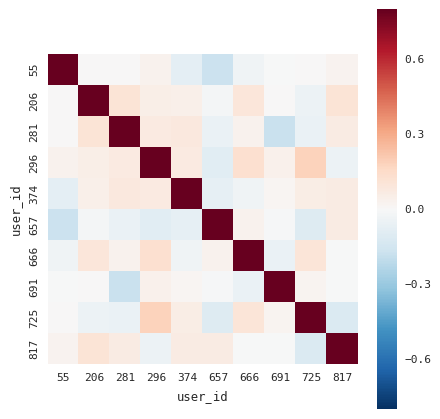

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(context="paper", font="monospace")

# Load the datset of correlations between cortical brain networks
#df = sns.load_dataset("brain_networks", header=[0, 1, 2], index_col=0)
#corrmat = user_sim.corr()
corrmat = utility_matrix.T.corr()
#display(corrmat)
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(5, 5))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=.8, square=True)

#f.tight_layout()
plt.show()

The above heat map shows that the user ID 374 is not strongly correlated with any other user IDs. Looking at the heat map it is difficult to decide how many nearest users (to user ID 374) are needed to predict the 374 user ratings accurately. So we will get the Mean Absolute Error (MEA) by including the nearest users to 374 user ID in an incremental fashion, and storing the MAE for each increment (k=1 to 10). We will pick the optimal K value, based on which K value has resulted in the least MAE.


In [42]:
held_movie_ids = list(X_test["item_id"])
held_movie_ids
held_movie_ratings=utility_matrix[held_movie_ids].T
held_movie_ratings
temp_ratings=pd.DataFrame(np.dot(held_movie_ratings,user_sim))
temp_ratings.index=held_movie_ratings.index
temp_ratings.columns=user_sim.index
#display(temp_ratings.head())

#def get_sum(l):
#    return np.sum(l)

#predicted_ratings=temp_ratings.apply(get_sum,axis=1)+mean_374_rating
#predicted_ratings=pd.DataFrame(predicted_ratings).reset_index().sort_values("item_id")
#predicted_ratings.index=predicted_ratings["item_id"]
#del(predicted_ratings["item_id"])
#predicted_ratings=predicted_ratings.T

#print "Predicted ratings using all the 10 users is given below:"
#display(predicted_ratings)

#print "Actual ratings"
actual_ratings=X_test.pivot(index="user_id",columns="item_id",values="rating")
#display(actual_ratings)
#print abs(predicted_ratings - actual_ratings)
#print "Mean absolute error is:"
#np.mean(abs(predicted_ratings.iloc[0] - actual_ratings.iloc[0]))



In [43]:
i = user_sim.loc[374].sort_values(ascending=False).index
print i
held_movie_ratings=held_movie_ratings[i]
user_374_sim=pd.DataFrame(user_sim.loc[374][i]).T
#display(user_374_sim)
#display(held_movie_ratings)
#display(user_374_sim[i[0:2]].T)
#display(held_movie_ratings[i[0:2]])

Int64Index([281, 296, 817, 725, 206, 691, 374, 666, 657, 55], dtype='int64', name=u'user_id')


In [44]:
error=[]
for k in range(1,len(i)+1):
    #display(np.dot(held_movie_ratings[i[0:k]],user_374_sim[i[0:k]].T)/sum(abs(user_374_sim[i[0:k]])))
    #display(np.dot(held_movie_ratings[i[0:k]],user_374_sim[i[0:k]].T)+mean_374_rating)
    predicted_ratings=np.dot(held_movie_ratings[i[0:k]],user_374_sim[i[0:k]].T)+mean_374_rating
    error.append(np.mean(abs(predicted_ratings - list(actual_ratings.iloc[0]))))
print error    


[1.2230643305829294, 1.2258902304148049, 1.2250113449865885, 1.2264392167769615, 1.2236044409202562, 1.2232900681518226, 1.2232900681518226, 1.2208537200815464, 1.2169297082691553, 1.2192706045910036]


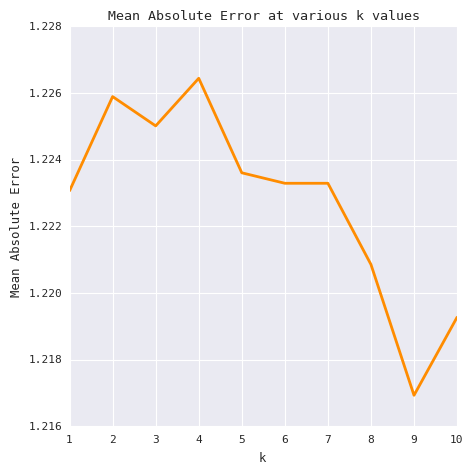

In [45]:
f, ax = plt.subplots(figsize=(5, 5))

# Draw the heatmap using seaborn
#sns.heatmap(corrmat, vmax=.8, square=True)

#f.tight_layout()
lw=2
ax.plot(range(1,len(i)+1),error, color='darkorange',lw=lw)
ax.set_ylabel('Mean Absolute Error')
ax.set_xlabel('k')
ax.set_title("Mean Absolute Error at various k values")


plt.show()

From the plot, we can infer that at k=9, the absolute error is minimal. However, we should note that there is no significant difference between the MAE values at various K values. To arrive at the optimal value of K, we have to perform the same kind of validation for other user IDs also. Moreover, we considered only 10 user IDs in this project and around 263 movies (rated by these 10 users). Our accuracy of the ratings would change if we consider the complete data set (100000 ratings). For content based recommendation we obtained a MAE of 1.24 and for user-user collaborative filtering we obtained a minimal error of 1.217 (approximately). So with this testing, we can conclude that the collaborative filtering is performing better (although the difference is marginal, and this conclusion may change if we consider the whole data set).

## Conclusion

In this project, we evaluated the content based filtering method using the actors as the features. Since the actors list (who acted in a specific movie) is not readily available, we had to scrape the IMDB website. This web scraping ran for 2 hours and many times it failed, as the connection was rejected by the server due to frequent bombardment of webpage requests by the web scraper. When the scraper completed successfully, we saved the actors list as a pickled object, so that we can avoid visiting the IMDB server again. The reason for choosing only 10 users is partly due to the work involved in scraping the website. For 10 users, we had to scrape 556 movies data, and obtained around 1700 actors list. If we had to build the actors list for the complete movies list, then the process would run for a long time (and also the system development would be challenging, unless we are using big data platform).

Based on the 10 users movie ratings, we could find that collaborative filtering recommendation system has better performance, and as a part of future work, we will work on the following:

1. Use item-item based collaborative method on the 10 users ratings, and check if the MAE decreases any further.
2. Use matrix factorization techniques to predict the ratings.
3. Use clustering techniques to predict the ratings
4. Compare all the algorithms performance
5. Scrape the complete actors list for all the 100K movies, and build actors list as features.
6. Check if the performance of algorithms change if they are trained on the whole data set.


### References:
1. F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets:
History and Context. ACM Transactions on Interactive Intelligent
Systems (TiiS) 5, 4, Article 19 (December 2015), 19 pages.
DOI=http://dx.doi.org/10.1145/2827872

2. Jure Leskovec, Anand Rajaraman and Jeffrey D. Ullman 2014. Mining of Massive Datasets (Chapter 9)